In [27]:
import numpy as np
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import torch
from torch import nn
from torch.utils.data import DataLoader
from torch.utils.data.dataset import Dataset
from torchvision import models, datasets
import torchvision.transforms as transforms
from tqdm.notebook import trange, tqdm
import matplotlib.pyplot as plt
from scipy.io import loadmat
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, random_split
import torchvision.models as models

# Hyperparameters
N_EPOCHS = 20
LEARNING_RATE = 0.001
TEST_SIZE=0.20

# Transformations for our dataset
transform = transforms.Compose([
    transforms.Resize((128, 128)),  # Resize images to 128x128
    transforms.ToTensor(),          # Convert PIL image to PyTorch tensor
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))  # Normalize to range [-1, 1] for better training stability
])

# Load the dataset
root_dir = 'data_zadanie2/'  # Modify this to the path where your image folders (cat, chicken, etc.) are located
full_dataset = datasets.ImageFolder(root=root_dir, transform=transform)

# Splitting the dataset
train_size = int((1 - TEST_SIZE) * len(full_dataset))
test_size = len(full_dataset) - train_size

train_dataset, test_dataset = random_split(full_dataset, [train_size, test_size])

# Dataloaders
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

In [28]:
# Load the pre-trained AlexNet model
alexnet = models.alexnet(pretrained=False)

# If you want to use the whole pre-trained model with the classification head
# Note that the classification head expects 1000 classes by default
# You may need to change the final fully connected layer for your specific number of classes
# The following code modifies the classification head for 10 classes:
alexnet.classifier[6] = nn.Linear(4096, 8)  # Change the output size for 10 classes

# Set the model to evaluation mode
alexnet.eval()

# Sample usage of the model
# input_tensor should be a 3x224x224 (RGB) image tensor
input_tensor = torch.randn(1, 3, 128, 128)  # Example random input
output = alexnet(input_tensor)



In [39]:
# initialize the models
cnn_model = alexnet
alexnet

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

In [30]:
# define the loss functions and optimizers
criterion = nn.CrossEntropyLoss()
cnn_optimizer = torch.optim.Adam(alexnet.parameters(), lr=LEARNING_RATE)

In [31]:
def evaluate_model(model, dataloader):
    """
    Evaluate the given model using the specified dataloader.

    Args:
    - model: Trained PyTorch model
    - dataloader: DataLoader for the evaluation data

    Returns:
    - Accuracy of the model on the evaluation data
    """
    correct = 0
    total = 0
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    model.eval()  # Set model to evaluation mode

    with torch.no_grad():  # No need to track gradients during evaluation
        for inputs, labels in tqdm(test_loader, desc="Evaluation", leave=False):
            inputs, labels = inputs.to(device).float(), labels.to(device)  # Move inputs and labels to the device and ensure float32 type
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = 100 * correct / total
    return accuracy

In [32]:
# Training
def train_model(model, optimizer, criterion, dataloader, epochs=30):
    """
    Train a given model using the specified optimizer and criterion.

    Args:
    - model: PyTorch model to be trained
    - optimizer: Optimizer for updating model parameters
    - criterion: Loss function
    - dataloader: DataLoader for the training data
    - epochs: Number of epochs (default=10)

    Returns:
    - list of losses per epoch
    """
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    model.train()  # Set the model to training mode
    loss_list = []  # To store the loss per epoch
    accuracy_list= []

    # Loop over epochs
    for epoch in trange(epochs, desc="Epochs"):
        # ... [rest of the code remains unchanged]
        epoch_loss = 0  # Initialize epoch loss

        for inputs, labels in tqdm(train_loader, desc="Batches", leave=False):
            inputs, labels = inputs.to(device).float(), labels.to(device)
            optimizer.zero_grad()  # Clear gradients
            outputs = model(inputs)  # Forward pass
            loss = criterion(outputs, labels)  # Calculate loss
            loss.backward()  # Backward pass
            optimizer.step()  # Update weights

            epoch_loss += loss.item()
        accuracy=evaluate_model(model, DataLoader(test_dataset, batch_size=64))
        accuracy_list.append(accuracy)
        avg_loss = epoch_loss / len(dataloader)
        loss_list.append(avg_loss)
        print(f"Epoch {epoch+1}/{epochs} - Loss: {avg_loss:.4f}")
    model.eval()
    return loss_list,accuracy_list

In [33]:
if torch.cuda.is_available():
    print("cuda")
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Assuming cnn_model is defined and moved to the correct device as well:
cnn_model.to(device)

# Training the CNN model
cnn_losses,cnn_accuracy_list = train_model(cnn_model, cnn_optimizer, criterion, DataLoader(train_dataset, batch_size=64, shuffle=True), epochs=N_EPOCHS)

# Evaluating the CNN model
cnn_accuracy = evaluate_model(cnn_model, DataLoader(test_dataset, batch_size=64))
print(f"CNN Model Accuracy: {cnn_accuracy:.2f}%")


cuda


Epochs:   0%|          | 0/20 [00:00<?, ?it/s]

Batches:   0%|          | 0/241 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/61 [00:00<?, ?it/s]

Epoch 1/20 - Loss: 2.0167


Batches:   0%|          | 0/241 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/61 [00:00<?, ?it/s]

Epoch 2/20 - Loss: 2.0025


Batches:   0%|          | 0/241 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/61 [00:00<?, ?it/s]

Epoch 3/20 - Loss: 2.0016


Batches:   0%|          | 0/241 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/61 [00:00<?, ?it/s]

Epoch 4/20 - Loss: 2.0012


Batches:   0%|          | 0/241 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/61 [00:00<?, ?it/s]

Epoch 5/20 - Loss: 2.0007


Batches:   0%|          | 0/241 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/61 [00:00<?, ?it/s]

Epoch 6/20 - Loss: 2.0012


Batches:   0%|          | 0/241 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/61 [00:00<?, ?it/s]

Epoch 7/20 - Loss: 2.0007


Batches:   0%|          | 0/241 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/61 [00:00<?, ?it/s]

Epoch 8/20 - Loss: 2.0010


Batches:   0%|          | 0/241 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/61 [00:00<?, ?it/s]

Epoch 9/20 - Loss: 2.0010


Batches:   0%|          | 0/241 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/61 [00:00<?, ?it/s]

Epoch 10/20 - Loss: 2.0008


Batches:   0%|          | 0/241 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/61 [00:00<?, ?it/s]

Epoch 11/20 - Loss: 2.0003


Batches:   0%|          | 0/241 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/61 [00:00<?, ?it/s]

Epoch 12/20 - Loss: 2.0002


Batches:   0%|          | 0/241 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/61 [00:00<?, ?it/s]

Epoch 13/20 - Loss: 2.0004


Batches:   0%|          | 0/241 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/61 [00:00<?, ?it/s]

Epoch 14/20 - Loss: 2.0004


Batches:   0%|          | 0/241 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/61 [00:00<?, ?it/s]

Epoch 15/20 - Loss: 1.9998


Batches:   0%|          | 0/241 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/61 [00:00<?, ?it/s]

Epoch 16/20 - Loss: 2.0002


Batches:   0%|          | 0/241 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/61 [00:00<?, ?it/s]

Epoch 17/20 - Loss: 1.9999


Batches:   0%|          | 0/241 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/61 [00:00<?, ?it/s]

Epoch 18/20 - Loss: 2.0004


Batches:   0%|          | 0/241 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/61 [00:00<?, ?it/s]

Epoch 19/20 - Loss: 2.0000


Batches:   0%|          | 0/241 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/61 [00:00<?, ?it/s]

Epoch 20/20 - Loss: 1.9998


Evaluation:   0%|          | 0/61 [00:00<?, ?it/s]

CNN Model Accuracy: 27.01%


In [34]:
import matplotlib.pyplot as plt

def plot_accuracy(accuracy_list, model_name):
    """
    Plots the accuracy for each epoch based on the provided accuracy list.

    Args:
    - accuracy_list: List of accuracy values (one for each epoch).
    - model_name: Name of the model, for labeling purposes.

    Returns:
    - None (Displays the plot)
    """
    
    plt.figure(figsize=(12, 6))
    plt.plot(accuracy_list, '-o', label=f'{model_name} Accuracy')
    plt.title(f'Accuracy Evolution for {model_name}')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy (%)')
    plt.legend()
    plt.grid(True, which='both', linestyle='--', linewidth=0.5)
    plt.tight_layout()
    plt.show()

# Example usage:
# plot_accuracy(mlp_accuracy_list, 'MLP')


In [35]:
import matplotlib.pyplot as plt

def plot_losses(mlp_losses, cnn_losses):
    # Initialize a new figure for plotting with a specified size.
    plt.figure(figsize=(12, 6))
    
    # Plot the MLP model's losses in blue.
    plt.plot(mlp_losses, label="MLP Model", color='blue')
    
    # Plot the CNN model's losses in red.
    plt.plot(cnn_losses, label="CNN Model", color='red')
    
    # Title of the plot.
    plt.title("Training Loss over Epochs")
    
    # Labels for the x and y axes.
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    
    # Display the legend to differentiate between MLP and CNN.
    plt.legend()
    
    # Display a grid for better readability.
    plt.grid(True)
    
    # Show the plot.
    plt.show()



In [36]:
import matplotlib.pyplot as plt

def plot_accuracy(accuracy_list, model_name):
    """
    Plots the accuracy for each epoch based on the provided accuracy list.

    Args:
    - accuracy_list: List of accuracy values (one for each epoch).
    - model_name: Name of the model, for labeling purposes.

    Returns:
    - None (Displays the plot)
    """
    
    plt.figure(figsize=(12, 6))
    plt.plot(accuracy_list, '-o', label=f'{model_name} Accuracy')
    plt.title(f'Accuracy Evolution for {model_name}')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy (%)')
    plt.legend()
    plt.grid(True, which='both', linestyle='--', linewidth=0.5)
    plt.tight_layout()
    plt.show()

# Example usage:
# plot_accuracy(mlp_accuracy_list, 'MLP')


In [37]:
def plot_filters(layer, layer_idx=0):
    # Extract filter weights from the layer and convert to numpy for visualization.
    filters = layer[layer_idx].weight.data.cpu().numpy()
    
    # Initialize a figure for displaying multiple images.
    fig = plt.figure(figsize=(10, 5))
    
    # Loop through each filter in the layer.
    for i in range(filters.shape[0]):
        ax = fig.add_subplot(2, filters.shape[0]//2, i+1) # arranging subplots in 2 rows.
        
        # Display the filter as an image.
        ax.imshow(filters[i][0], cmap='gray')
        
        # Don't show axis for clarity.
        ax.axis('off')
    
    # Show all the filter images.
    plt.show()



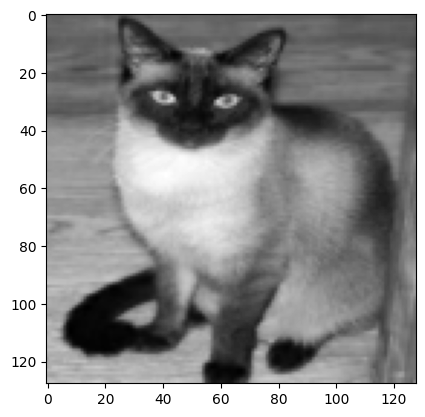

AttributeError: 'AlexNet' object has no attribute 'conv1'

In [38]:
def visualize_feature_maps(model, input_image):
    # Making sure model is in eval mode
    model.eval()
    
    # Running the image through the first conv layer
    feature_maps1 = model.conv1(input_image.unsqueeze(0).float().to(device))
    # If you want to visualize after the second conv layer
    # feature_maps2 = model.conv2(F.relu(feature_maps1))
    
    n_feature_maps = feature_maps1.shape[1]
    
    # Plotting each feature map
    for i in range(n_feature_maps):
        plt.subplot(8, 8, i+1)  # Assuming a max of 64 feature maps for display
        plt.imshow(feature_maps1[0][i].cpu().detach().numpy(), cmap='gray')
        plt.axis('off')
    plt.show()

# Select a random image from the dataset
image, _ = test_dataset[5]
plt.imshow(image[0], cmap='gray')  # Displaying the selected image
plt.show()

# Displaying feature maps for the selected image
visualize_feature_maps(cnn_model, image)

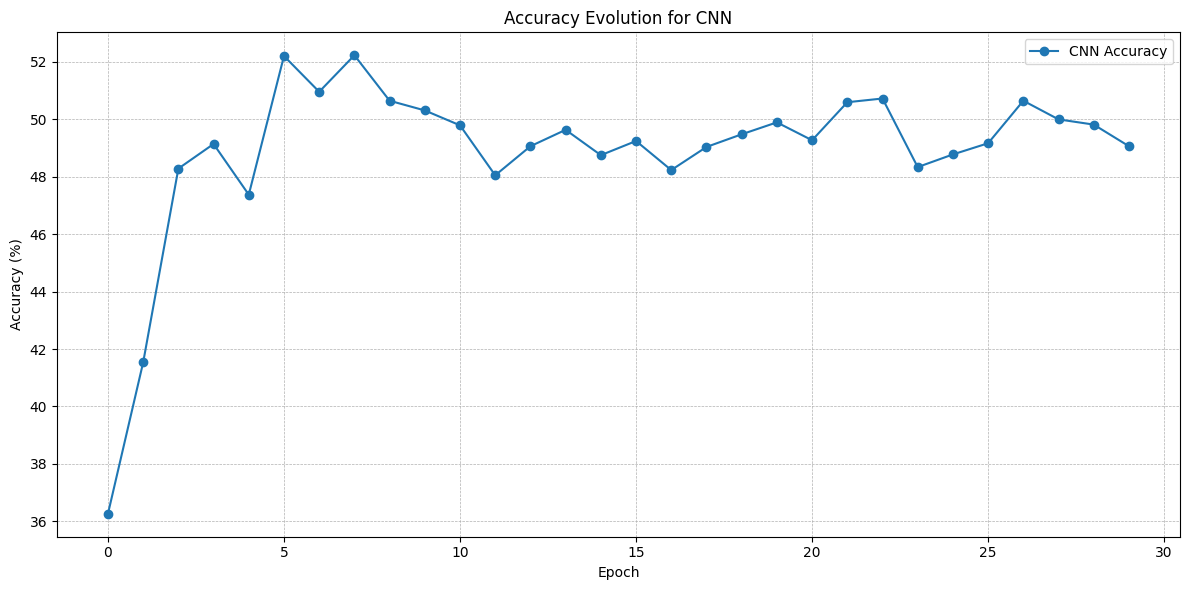

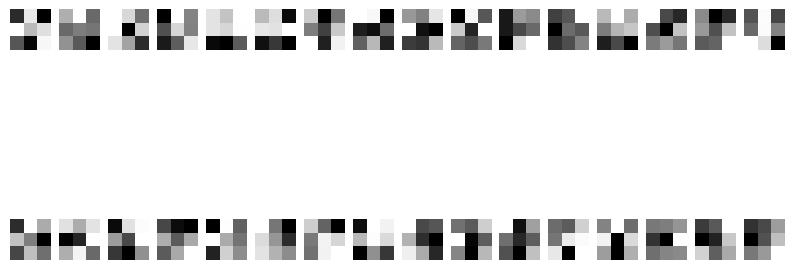

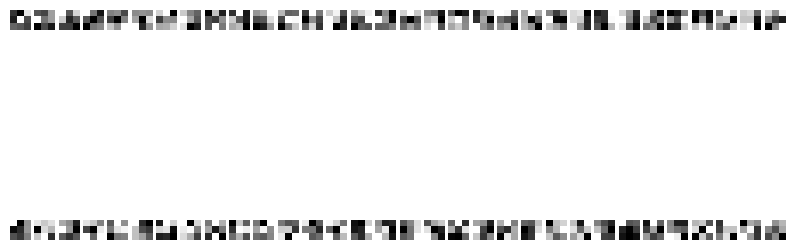

In [ ]:
plot_accuracy(cnn_accuracy_list, "CNN")
plot_filters(cnn_model.conv1,0)
plot_filters(cnn_model.conv2,0)

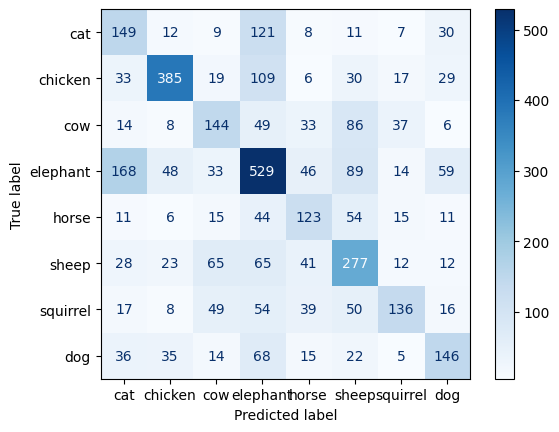

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

def get_all_preds_and_labels(model, dataloader):
    # Empty tensors to store all predictions and true labels.
    all_preds = torch.tensor([]).to(device)
    all_labels = torch.tensor([]).to(device)
    
    # Loop through the data in the dataloader.
    for inputs, labels in dataloader:
        # Convert inputs to float32
        inputs = inputs.float()
        # Move the data to the device (GPU/CPU).
        inputs, labels = inputs.to(device), labels.to(device)
        
        # Forward pass to get predictions.
        outputs = model(inputs)
        
        # Get the index (class label) with the maximum score as the prediction.
        _, preds = torch.max(outputs, 1)
        
        # Append the batch's predictions and labels to the accumulating tensors.
        all_preds = torch.cat((all_preds, preds), dim=0)
        all_labels = torch.cat((all_labels, labels), dim=0)
    
    # Return all predictions and true labels.
    return all_preds, all_labels

import numpy as np
from sklearn import metrics

def plot_confusion_matrix(all_preds, all_labels):
    # Compute the confusion matrix using sklearn's function.
    cm = metrics.confusion_matrix(all_labels.cpu(), all_preds.cpu())
    
    # Define the labels you're using (in this case, it's A-J).
    labels = ["cat","chicken","cow","dog","elephant","horse","sheep","squirrel"]
    
    # Create the ConfusionMatrixDisplay object.
    cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
    
    # Plot the confusion matrix.
    cm_display.plot(cmap='Blues')
    plt.show()

# After training your CNN model
cnn_model = cnn_model.float()
all_preds, all_labels = get_all_preds_and_labels(cnn_model, DataLoader(test_dataset, batch_size=64))
plot_confusion_matrix(all_preds, all_labels)
